# Introduction

The business problem is to classify whether a video segment is a commercial or part of the scheduled TV news channel. This is a small, sub-problem of Broadcast Monitoring, which aims to identify content being broadcasted. Unlike TV news segments, commercials tend to have high energy and fast transitions with the aim to grab the consumers attention. These characteristics are quantified in our dataset with complex industry-specific features such as spectral flux, or ZCR. Using this dataset, the learned model can detect if a video segment is a commercial. This model will provide business value by enforcing ad-coverage laws. If a company claims it airs 15% less commercials than a competitor, it would be possible to verify this claim using the machine learning model. Also, this model would enable organizations to generate statistics about the airing time of advertisements. This can help organizations to adjust their advertisement strategy to maximize results. 

# Data Description

Link to dataset: https://archive.ics.uci.edu/ml/datasets/TV+News+Channel+Commercial+Detection+Dataset

A TV News Channel Commercial dataset is being used for this project. It was found by filtering the datasets on UCI by number of instances, and then looking for a dataset with a moderate amount of features, minimal missing values, and having interesting relevant data. This dataset has 129,685 rows and 4125 columns of data. These features are all numerical values that represent metadata from audio and video sources. Approximately 63% of the dataset are commercials, with a positive class label and there are no NaN values within the dataset. The features or columns of this dataset all contain metadata and metadata summaries of the actual audio and video of the TV stream.

# Imports and Data Loading

In [ ]:
import pandas as pd
import numpy as np
import scipy as sc
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score,recall_score,f1_score,matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from math import log10
from sklearn.model_selection import cross_val_score
import shap
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [95]:
#ndtv = load_svmlight_file("/kaggle/input/tv-news-channel-commercial-detection-dataset/NDTV.txt")
#cnn = load_svmlight_file("/kaggle/input/tv-news-channel-commercial-detection-dataset/CNN.txt")
#bbc = load_svmlight_file("/kaggle/input/tv-news-channel-commercial-detection-dataset/BBC.txt")
#cnnibn = load_svmlight_file("/kaggle/input/tv-news-channel-commercial-detection-dataset/CNNIBN.txt")
#imesnow = load_svmlight_file("/kaggle/input/tv-news-channel-commercial-detection-dataset/TIMESNOW.txt")

In [96]:
# Loading all our data. Same format from different files representing different television channels.
ndtv = load_svmlight_file("D:/data_storage/Projects/ml_commercial_detection/TV_News_Channel_Commercial_Detection_Dataset/NDTV.txt")
cnn = load_svmlight_file("D:/data_storage/Projects/ml_commercial_detection/TV_News_Channel_Commercial_Detection_Dataset/CNN.txt")
bbc = load_svmlight_file("D:/data_storage/Projects/ml_commercial_detection/TV_News_Channel_Commercial_Detection_Dataset/BBC.txt")
cnnibn = load_svmlight_file("D:/data_storage/Projects/ml_commercial_detection/TV_News_Channel_Commercial_Detection_Dataset/CNNIBN.txt")
timesnow = load_svmlight_file("D:/data_storage/Projects/ml_commercial_detection/TV_News_Channel_Commercial_Detection_Dataset/TIMESNOW.txt")

In [97]:
# Combining all 5 channels into one
x, y = sc.sparse.vstack([ndtv[0], cnn[0], bbc[0], cnnibn[0], timesnow[0]]), np.concatenate([ndtv[1], cnn[1], bbc[1], cnnibn[1], timesnow[1]])

# Exploratory Data Analysis

Below we see x and y have the same rows which means the data has been combined well

In [98]:
x.shape, y.shape

((129685, 4125), (129685,))

In [99]:
type(x)

scipy.sparse._csr.csr_matrix

In [100]:
# Convert from a sparse matrix to a pandas Dataframe
df = pd.DataFrame.sparse.from_spmatrix(x)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4115,4116,4117,4118,4119,4120,4121,4122,4123,4124
0,29.0,3.821209,1.567568,13.547628,7.242389,0.019883,0.012195,0.067241,0.049107,3406.866211,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.524255,0.866498
1,25.0,3.052969,1.641484,22.334589,15.734018,0.023027,0.010731,0.077000,0.045884,3324.158203,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072369,0.534711
2,82.0,1.601274,1.508805,5.860583,3.301121,0.025948,0.006956,0.082317,0.044845,3771.984131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.552685,0.918764
3,25.0,4.819368,2.879584,41.382828,24.448074,0.014387,0.007596,0.069875,0.046916,3301.686035,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.117911,0.223210
4,29.0,2.768753,1.797319,13.338054,9.980667,0.011506,0.007269,0.100647,0.067401,3266.021484,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.529581,0.968130


For the datatypes, as seen below, we have all columns made of Sparse matrices, whereas it should be float. We will fix this in the next section

In [101]:
df.dtypes

0       Sparse[float64, 0]
1       Sparse[float64, 0]
2       Sparse[float64, 0]
3       Sparse[float64, 0]
4       Sparse[float64, 0]
               ...        
4120    Sparse[float64, 0]
4121    Sparse[float64, 0]
4122    Sparse[float64, 0]
4123    Sparse[float64, 0]
4124    Sparse[float64, 0]
Length: 4125, dtype: object

In [102]:
df.count()

0       129685
1       129685
2       129685
3       129685
4       129685
         ...  
4120    129685
4121    129685
4122    129685
4123    129685
4124    129685
Length: 4125, dtype: int64

In [103]:
df.isnull().sum()

0       0
1       0
2       0
3       0
4       0
       ..
4120    0
4121    0
4122    0
4123    0
4124    0
Length: 4125, dtype: int32

# Data Preprocessing

For preprocessing, first we will drop all bag of word and binned data. The first 17 columns of our data set have mean and variance values, thus, we can afford to lose the individual bins.

In [104]:
df.drop(df.iloc[:, 17:4123], inplace=True, axis=1)

In [105]:
df.shape

(129685, 19)

Here we will convert all our rows to float from sparse.

In [106]:
for i in df.columns:
    df[i] = df[i].values.to_dense().astype(np.float64)

In [107]:
df.dtypes

0       float64
1       float64
2       float64
3       float64
4       float64
5       float64
6       float64
7       float64
8       float64
9       float64
10      float64
11      float64
12      float64
13      float64
14      float64
15      float64
16      float64
4123    float64
4124    float64
dtype: object

Next step is to add the labels to our dataframe for when we split our dataset by rows.

In [108]:
df['label'] = y.astype(int).tolist()

In [109]:
df['label'].value_counts()

 1    82231
-1    47454
Name: label, dtype: int64

As seen above, the labels are 1 and -1. Since binary labels are preferred, -1 is converted to 0 below

In [110]:
df.loc[df['label'] == -1, 'label'] = 0
df['label'].value_counts()

1    82231
0    47454
Name: label, dtype: int64

Let's give the non bag of words features their names

In [112]:
#Let's give the columns their names
df.rename(columns={
 0:'shot_length',
 1:'motion_distribution_mean',
 2:'motion_distribution_variance',
 3:'frame_difference_distribution_mean',
 4:'frame_difference_distribution_variance',
 5:'short_time_energy_mean',
 6:'short_time_energy_variance',
 7:'zcr_mean',
 8:'zcr_variance',
 9:'spectral_centroid_mean',
 10:'spectral_centroid_variance',
 11:'spectral_roll_off_mean',
 12:'spectral_roll_off_variance',
 13:'spectral_flux_mean',
 14:'spectral_flux_variance',
 15:'fundamental_frequency_mean',
 16:'fundamental_frequency_variance',
 4123:'edge_change_ratio_mean',
 4124:'edge_change_ratio_variance'
},inplace=True)

In [113]:
df

,shot_length,motion_distribution_mean,motion_distribution_variance,frame_difference_distribution_mean,frame_difference_distribution_variance,short_time_energy_mean,short_time_energy_variance,zcr_mean,zcr_variance,spectral_centroid_mean,spectral_centroid_variance,spectral_roll_off_mean,spectral_roll_off_variance,spectral_flux_mean,spectral_flux_variance,fundamental_frequency_mean,fundamental_frequency_variance,edge_change_ratio_mean,edge_change_ratio_variance,label
0,29.0,3.821209,1.567568,13.547628,7.242389,0.019883,0.012195,0.067241,0.049107,3406.866211,1363.990601,6796.552246,2719.626709,1021.359192,940.742371,102.607803,60.178288,0.524255,0.866498,1
1,25.0,3.052969,1.641484,22.334589,15.734018,0.023027,0.010731,0.077000,0.045884,3324.158203,1452.020752,6610.000488,2885.445312,1199.364380,821.123535,84.687698,46.896881,0.072369,0.534711,1
2,82.0,1.601274,1.508805,5.860583,3.301121,0.025948,0.006956,0.082317,0.044845,3771.984131,855.766479,7488.112305,1697.350586,1544.147461,807.137268,92.694611,41.182648,0.552685,0.918764,1
3,25.0,4.819368,2.879584,41.382828,24.448074,0.014387,0.007596,0.069875,0.046916,3301.686035,1441.997681,6606.000977,2883.914795,599.555176,535.151978,96.595497,61.861046,0.117911,0.223210,1
4,29.0,2.768753,1.797319,13.338054,9.980667,0.011506,0.007269,0.100647,0.067401,3266.021484,1432.114868,6688.794922,2678.393799,446.452423,411.464722,95.036949,48.364391,0.529581,0.968130,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129680,41.0,0.558875,0.247396,2.279039,0.798749,0.023244,0.011390,0.057546,0.035940,3568.417236,1174.369995,7117.683594,2340.709717,1665.174072,1823.522583,87.497238,44.907471,0.190005,0.946195,1
129681,105.0,6.594097,3.418464,17.372873,8.571255,0.020726,0.010193,0.085179,0.051084,3810.282715,760.784424,7528.095215,1502.876709,1426.169800,1907.535034,115.274689,49.007130,0.166974,0.728715,1
129682,100.0,1.299783,0.543502,5.095611,1.527174,0.018389,0.008418,0.104063,0.045564,3817.707275,781.546814,7468.751465,1527.582520,1217.222534,1342.270996,132.880142,51.955788,0.928798,0.437874,1
129683,60.0,0.571542,0.487061,2.218786,2.174240,0.018031,0.007570,0.122708,0.050065,3720.528809,995.352417,7237.083496,1936.077393,896.837219,827.654297,124.423271,51.549557,0.745411,0.260724,1


### Important note on the bag of words

We later realized that the bag of words did not actually represent the occurrences of certain words, but is an MFCC bag of audio words. This MFCC (Mel-frequency cepstral coefficients) which is a representation of the short-term power spectrum of a sound, relative to each other. 

In the end, the data in those columns is still a measure of what is being said on the broadcast, and it can still be processed as a regular bag of words would. We will still refer to those features as bag of words. 

Since bag of words has a different meaning to the mean and variance data (Columns 0:17), here we process another dataframe with just bag of words

In [114]:
tf= pd.DataFrame(np.array(sc.sparse.csr_matrix.toarray(x))).iloc[:,123:4123]
tf

,123,124,125,126,127,128,129,130,131,132,...,4113,4114,4115,4116,4117,4118,4119,4120,4121,4122
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129683,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The next few steps are for making the tf_idf dataframe

In [115]:
# Number of documents contains a word(column)
documents = []

for j in range(len(tf.iloc[0, :])):
  count = sum( i > 0 for i in tf.iloc[:, j])
  documents.append(count)
documents

[0,
 6840,
 0,
 11431,
 211,
 37737,
 838,
 691,
 0,
 0,
 22647,
 0,
 0,
 1386,
 0,
 0,
 0,
 493,
 39605,
 4496,
 12528,
 9099,
 0,
 0,
 0,
 21629,
 0,
 0,
 40197,
 0,
 0,
 0,
 33274,
 0,
 0,
 0,
 0,
 0,
 19263,
 0,
 0,
 0,
 7065,
 0,
 31404,
 0,
 0,
 16497,
 0,
 0,
 0,
 0,
 30762,
 0,
 3294,
 0,
 0,
 0,
 13669,
 0,
 0,
 25292,
 14348,
 22041,
 12789,
 0,
 0,
 0,
 17277,
 0,
 13405,
 12244,
 0,
 8809,
 16,
 0,
 0,
 0,
 0,
 438,
 0,
 0,
 5855,
 0,
 11758,
 6195,
 0,
 0,
 841,
 0,
 0,
 4625,
 0,
 0,
 0,
 21490,
 4181,
 55787,
 0,
 1459,
 0,
 0,
 0,
 0,
 0,
 2132,
 3873,
 4536,
 0,
 2590,
 873,
 0,
 19475,
 0,
 0,
 0,
 4676,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 17972,
 0,
 0,
 0,
 0,
 0,
 0,
 5897,
 0,
 14040,
 0,
 0,
 0,
 0,
 43044,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 85335,
 0,
 0,
 0,
 19938,
 0,
 0,
 0,
 0,
 0,
 0,
 2864,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5022,
 0,
 5665,
 0,
 0,
 0,
 0,
 10,
 

In [116]:
#Calculating idf
number_of_documents = sum(tf.iloc[0:, ])
number_of_documents
idf = []
for i in documents:
  value = 0
  if i > 0:
    value = log10(number_of_documents / i)
  else:
    value = 0

  idf.append(value)
idf

[0,
 3.0938515885238367,
 0,
 2.870823465493028,
 4.60462523494626,
 2.3521403184010596,
 4.005663671613676,
 4.089429642869754,
 0,
 0,
 2.5738970101528063,
 0,
 0,
 3.7871444599681645,
 0,
 0,
 0,
 4.236060770966723,
 2.3311576726181085,
 3.276081387682948,
 2.8310259455300844,
 2.969914025213627,
 0,
 0,
 0,
 2.593871249608439,
 0,
 0,
 2.3247140484048354,
 0,
 0,
 0,
 2.4068026779682503,
 0,
 0,
 0,
 0,
 0,
 2.6441837656077958,
 0,
 0,
 0,
 3.0797955240593753,
 0,
 2.4319227215564467,
 0,
 0,
 2.711502715842411,
 0,
 0,
 0,
 0,
 2.4408931224199097,
 0,
 3.411184095410217,
 0,
 0,
 0,
 2.793170946734479,
 0,
 0,
 2.525924517102772,
 2.7721163222400236,
 2.5856763956799136,
 2.822071102877158,
 0,
 0,
 0,
 2.6914393569943837,
 0,
 2.8016408719250543,
 2.840984369318656,
 0,
 2.983981080257737,
 5.724787707588028,
 0,
 0,
 0,
 0,
 4.2874335797398535,
 0,
 0,
 3.1613807908355707,
 0,
 2.8585742343908898,
 3.1368663795318703,
 0,
 0,
 4.00411169444604,
 0,
 0,
 3.263795953168901,
 0,
 0

In [117]:
#Calculating tf_idf
tf_idf = tf.copy()
tf_idf *= idf

We can see that many of those words are found in none of document. In other words, every value in the columns are zero. Therefore we will drop them as they are of no use.

In [118]:
tf_idf=tf_idf.iloc[:,np.nonzero(idf)[0].tolist()]
tf_idf.shape

(129685, 111)

Finally, the following are the final datasets. bag_ for bag of words data and nbag_ (stands for non-bag of words) for mean and variance feature data

In [119]:
bag_x=tf_idf
bag_y=df['label']
bag_data=tf_idf.join(df['label'])
nbag_x=df.drop(['label'], axis='columns')
nbag_y=df['label']
nbag_data=df

# Base model and predictions

The `accuracy` function helps us cross validate the accuracy of models and outputs the classification report for them

In [126]:
def accuracy(model,x_data,y_data):
  #10 Fold cross validation
  print("10 Fold CV score: ")
  score=cross_val_score(model,x_data,y_data,cv=10).mean()
  print(score)
  x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, random_state=102, stratify=y_data)
  model.fit(x_train,y_train)
  y_pred=model.predict(x_test)
  #Confusion Matrix
  cm = confusion_matrix(y_test, y_pred)
  # Normalise
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  fig, ax = plt.subplots(figsize=(2,2))
  sns.heatmap(cmn, annot=True, fmt='.2f')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show(block=False)
  #classification report
  print(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)))

##### Here is the base model accuracy for feature mean and variance data

In [122]:
clf = DecisionTreeClassifier()

10 Fold CV score: 
0.8911290205196286


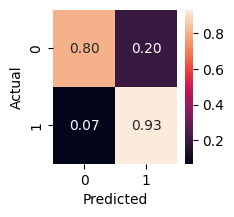

                     0             1  accuracy     macro avg  weighted avg
precision     0.870795      0.889801  0.883411      0.880298      0.882847
recall        0.800084      0.931496  0.883411      0.865790      0.883411
f1-score      0.833943      0.910171  0.883411      0.872057      0.882279
support    7118.000000  12335.000000  0.883411  19453.000000  19453.000000


In [123]:
accuracy(clf,nbag_x,nbag_y)

##### Here is the base model accuracy for the bag of words data

10 Fold CV score: 
0.907144710237467


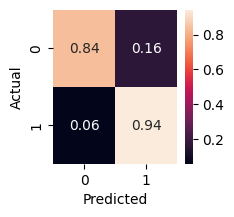

                     0             1  accuracy     macro avg  weighted avg
precision     0.895534      0.910570  0.905413      0.903052      0.905068
recall        0.839421      0.943494  0.905413      0.891458      0.905413
f1-score      0.866570      0.926740  0.905413      0.896655      0.904723
support    7118.000000  12335.000000  0.905413  19453.000000  19453.000000


In [127]:
accuracy(clf,bag_x,bag_y)

# Exploring different ways of improving accuracy

### 1. Undersampling to reduce label imbalance

##### Undersampling for Feature Mean and Variance data

In [128]:
#Splitting the data by label
df_zero = df.loc[df['label'] == 0,:]
df_one = df.loc[df['label'] == 1,:]
df_zero.shape, df_one.shape

((47454, 20), (82231, 20))

10 Fold CV score: 
0.8554600059798207


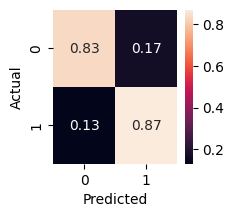

                     0            1  accuracy     macro avg  weighted avg
precision     0.865121     0.839274  0.851724      0.852197      0.852198
recall        0.833404     0.870048  0.851724      0.851726      0.851724
f1-score      0.848966     0.854384  0.851724      0.851675      0.851675
support    7119.000000  7118.000000  0.851724  14237.000000  14237.000000


In [129]:
clf = DecisionTreeClassifier()
data=pd.concat(
  [
    nbag_data.loc[df['label'] == 0,:].sample(n=47454,random_state=42),
    nbag_data.loc[df['label'] == 1,:].sample(n=47454,random_state=42)
  ]
)
accuracy(clf,data.drop(['label'], axis='columns'),data['label'])

##### Undersampling for Bag of Words data

10 Fold CV score: 
0.8757744173144344


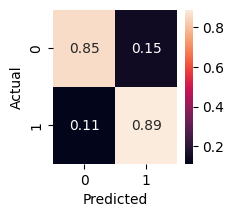

                     0            1  accuracy     macro avg  weighted avg
precision     0.883181     0.859379    0.8709      0.871280      0.871281
recall        0.854895     0.886906    0.8709      0.870901      0.870900
f1-score      0.868808     0.872926    0.8709      0.870867      0.870867
support    7119.000000  7118.000000    0.8709  14237.000000  14237.000000


In [130]:
data=pd.concat(
  [
    bag_data.loc[df['label'] == 0,:].sample(n=47454,random_state=42),
    bag_data.loc[df['label'] == 1,:].sample(n=47454,random_state=42)
  ]
)
accuracy(clf,data.drop(['label'], axis='columns'),data['label'])

#### 1. Conclusion
Undersampling does not do us any favor. The accuracy is reduced. This technique should be discarded

## 2. Oversampling to reduce label imbalancer

Doing a fair comparison with oversampling is little hard because if kfold cross validation is used, then really we are testing the accuracy with on test data that is a also found in the training set (because we duplicated it).

##### Data processing for Feature Mean and Variance data

In [131]:
clf = DecisionTreeClassifier()

We are doing train test split before hand. That way we can duplicate train data and test on another set that we know does not contain duplicates.

In [132]:
x_train, x_test, y_train, y_test = train_test_split(nbag_x, nbag_y, test_size=0.15, random_state=102, stratify=nbag_y)
nbag_train=x_train.join(y_train)
nbag_test=x_test.join(y_test)
nbag_train.shape

(110232, 20)

In [133]:
#Let's split the training set by label
df_zero = nbag_train.loc[df['label'] == 0,:]
df_one = nbag_train.loc[df['label'] == 1,:]
df_zero.shape, df_one.shape

((40336, 20), (69896, 20))

In [134]:
nbag_zero_duplicated=nbag_train.loc[df['label'] == 0,:].sample(n=29560,random_state=42)
data=pd.concat(
  [
    nbag_train,
    nbag_zero_duplicated
  ]
)

In [135]:
data.loc[df['label'] == 0,:].shape,data.loc[df['label'] == 1,:].shape

((69896, 20), (69896, 20))

Looks good

##### Oversampling for Feature Mean and Variance data

In [136]:
clf.fit(data.drop(['label'], axis='columns'), data['label'])
y_pred = clf.predict(nbag_test.drop(['label'], axis='columns'))
accuracy_score(nbag_test['label'], y_pred)

0.886084408574513

##### Oversampling for Bag of Words data

Now we repeat the same process on bagf of words

In [137]:
x_train, x_test, y_train, y_test = train_test_split(bag_x, bag_y, test_size=0.15, random_state=102, stratify=bag_y)
bag_train=x_train.join(y_train)
bag_test=x_test.join(y_test)
bag_train.shape

(110232, 112)

In [138]:
bag_zero_duplicated=bag_train.loc[df['label'] == 0,:].sample(n=29560,random_state=42)
data=pd.concat(
  [
    bag_train,
    bag_zero_duplicated
  ]
)

In [139]:
data.loc[df['label'] == 0,:].shape,data.loc[df['label'] == 1,:].shape

((69896, 112), (69896, 112))

In [140]:
clf.fit(data.drop(['label'], axis='columns'), data['label'])
y_pred = clf.predict(bag_test.drop(['label'], axis='columns'))
accuracy_score(bag_test['label'], y_pred)

0.9066981956510564

#### 2. Conclusion
Given that we did not do 10 fold cross-validation, it is hard to make a fair comparison. However, given that the results were both slightly lower for the fold we tested it on, if there is any benefit to this method, it is likely not worth the hassle. This technique should be discarded.

## 3. Feature scaling to reduce outlier influence

In this section we are going to standardize the mean and variance features.

In [141]:
nbag_scaled = nbag_data.drop(['label'], axis='columns').copy()
nbag_scaled.values[:] = StandardScaler().fit_transform(nbag_data.drop(['label'], axis='columns'))

10 Fold CV score: 
0.8904736001699873


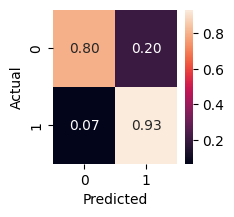

                     0             1  accuracy     macro avg  weighted avg
precision     0.873406      0.889292  0.883977      0.881349      0.883479
recall        0.798679      0.933198  0.883977      0.865939      0.883977
f1-score      0.834373      0.910716  0.883977      0.872545      0.882782
support    7118.000000  12335.000000  0.883977  19453.000000  19453.000000


In [142]:
accuracy(clf,nbag_scaled,nbag_y)

### 3. Conclusion
As we can see, the accuracy is very slightly worse by 0.1%. Therefore this technique should be discarded as well.

## 4. Feature selection

In this section we will explore if removing some bad features can help our accuracy. Bad features are the features that make the least impact on the output of the model. The importance is the column that gives each feature an relative 'weight' for importance.

Let's look at the relative usefulness of each mean and variance feature

In [147]:
imp=pd.DataFrame(mutual_info_classif(nbag_x,nbag_y),index=nbag_x.columns)
imp.columns=['Importance']
imp.sort_values(by='Importance',ascending=False)

,Importance
fundamental_frequency_mean,0.221935
spectral_roll_off_variance,0.214769
spectral_centroid_variance,0.210403
spectral_flux_variance,0.208018
spectral_centroid_mean,0.198066
spectral_roll_off_mean,0.184444
fundamental_frequency_variance,0.173472
spectral_flux_mean,0.173053
motion_distribution_variance,0.169162
frame_difference_distribution_variance,0.167232


As we can see, feature edge_change_ration_mean, edge_change_ratio_variance and shot_length contain very little information about the label. Let's drop them and watch what happens.

In [148]:
nbag_selective_features = nbag_x.copy()
nbag_selective_features.drop(list(nbag_selective_features.columns[imp['Importance'] < 0.1]), axis='columns', inplace=True)

10 Fold CV score: 
0.9041529250051932


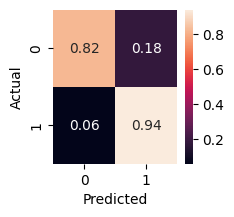

                     0             1  accuracy     macro avg  weighted avg
precision     0.890542      0.902689  0.898576      0.896616      0.898244
recall        0.824108      0.941548  0.898576      0.882828      0.898576
f1-score      0.856038      0.921709  0.898576      0.888874      0.897680
support    7118.000000  12335.000000  0.898576  19453.000000  19453.000000


In [149]:
accuracy(clf,nbag_selective_features,nbag_y)

#### 4. Conclusion
Removing those features improved our accuracy by 1% of the original. Therefore, those 3 features should be dropped from the data of the final model.

#### Let's used this better subset of features for the upcoming techniques

## 5. Combining the bag of words and feature mean and variance data

Let's try to see if combining the two sets of data helps accuracy.

In [156]:
#Convert the bag_x colummn names to string for merging purposes
bag_x.columns=bag_x.columns.astype(str)

In [157]:
all_data_x=nbag_selective_features.join(bag_x)
all_data_y=nbag_y
all_data_x.shape

(129685, 127)

10 Fold CV score: 
0.9109000474914104


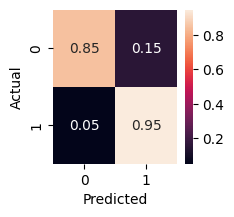

                     0             1  accuracy     macro avg  weighted avg
precision     0.901255      0.914962  0.910245      0.908108      0.909946
recall        0.847570      0.946413  0.910245      0.896991      0.910245
f1-score      0.873588      0.930422  0.910245      0.902005      0.909626
support    7118.000000  12335.000000  0.910245  19453.000000  19453.000000


In [158]:
accuracy(clf,all_data_x,all_data_y)

#### 5. Conclusion
We are now doing better than both the selected best mean and variance feature alone and the bag of words features alone. Therefore we should use the combined data for the final model.

## 6. Hyperparameter Tuning

For our final technique we will do a little bit of hyperparametr tuning. Note that the search space below is no very exhaustive because it takes quite a long time to run these. We also lower the cross validation to 5 to make it run faster as well.

In [163]:
all_data_x.shape

(129685, 127)

In [180]:
t_clf=DecisionTreeClassifier()
search_space={
    'max_depth':[None,131],
    'min_samples_split':[2,10],
    'criterion':['gini','entropy','log_loss']
}
gscv=GridSearchCV(estimator=t_clf,param_grid=search_space,verbose=0,cv=5)

As mentioned before, this grid search is far from exhaustive. However it is enough to choose the best criterion, enough to tell us if the ideal max_depth is lower than None and enough to tell us if the ideal min_samples_split is significantly higher than the default. Now this is not fully true as perhaps some combination of a different max_depth and higher min_samples_split that isn't in the search space might be better, but this search is still useful to determine the best criterion and gain confidence that the default max_depth and min_samples_split are decent values (or not).

In [181]:
gscv.fit(all_data_x,all_data_y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 131],
                         'min_samples_split': [2, 10]})

In [182]:
gscv.best_params_

{'criterion': 'log_loss', 'max_depth': 131, 'min_samples_split': 2}

The parameters that aren't the default are the criterion and the max_depth.

Let's test the Decision Tree with 'log_loss' criterion and max_depth=131 on 10 folds just to be sure it is better.

10 Fold CV score: 
0.9124345447162977


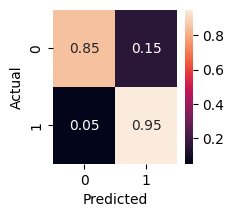

                     0             1  accuracy     macro avg  weighted avg
precision     0.904505      0.915832  0.911942      0.910168      0.911687
recall        0.848974      0.948277  0.911942      0.898626      0.911942
f1-score      0.875861      0.931772  0.911942      0.903816      0.911314
support    7118.000000  12335.000000  0.911942  19453.000000  19453.000000


In [184]:
clf=DecisionTreeClassifier(criterion='log_loss',max_depth=131)
accuracy(clf,all_data_x,all_data_y)

#### 6. Conclusion
As we can see, the performance of the tuned model is 0.2% better than the previous best. It is not a big difference but it is a very change to make, therefore our final model should use 'log_loss' as the criterion and a max_depth of 131.

# Building and evaluating our final model

Let's summarize our findings so far

In order to build best model, we need to:
- Train it on the joined data
- Pick only the best mean and variance features
- Use the 'entropy' criterion


We also learned that it is not useful to:
- Do over or under sampling
- Scale the mean and variance features

#### Let's set our final data and fina model

In [185]:
#set the final data
final_x=all_data_x
final_y=all_data_y

In [194]:
#set the final model
best_model=DecisionTreeClassifier(criterion='log_loss',max_depth=131)

10 Fold CV score: 
0.9135834733126481


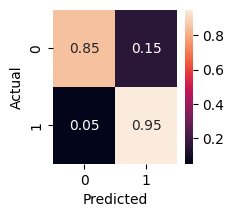

                     0             1  accuracy     macro avg  weighted avg
precision     0.903728      0.915297  0.911325      0.909512      0.911064
recall        0.847991      0.947872  0.911325      0.897931      0.911325
f1-score      0.874973      0.931300  0.911325      0.903136      0.910689
support    7118.000000  12335.000000  0.911325  19453.000000  19453.000000


In [195]:
accuracy(best_model,final_x,final_y)

# What characterises a commercial? A model explanation

Let's take a look at how the features impact the prediction

For the shap visualizations, we will take a smaller subset of the data to accelerate calculations. The results should still be a good enough approximation of the final model trained on the final data.

In [196]:
small_final_x=final_x.sample(n=1000,random_state=42)
small_final_y=final_y.sample(n=1000,random_state=42)

In [197]:
best_model.fit(small_final_x,small_final_y)
explainer=shap.Explainer(best_model.predict,small_final_x)
sv=explainer(small_final_x)

Permutation explainer: 1001it [00:55, 14.61it/s]                          


Let's look at commercial and non commercial example

In [198]:
#Look for non commercial example
a=1
#Look for a commercial example
b=2


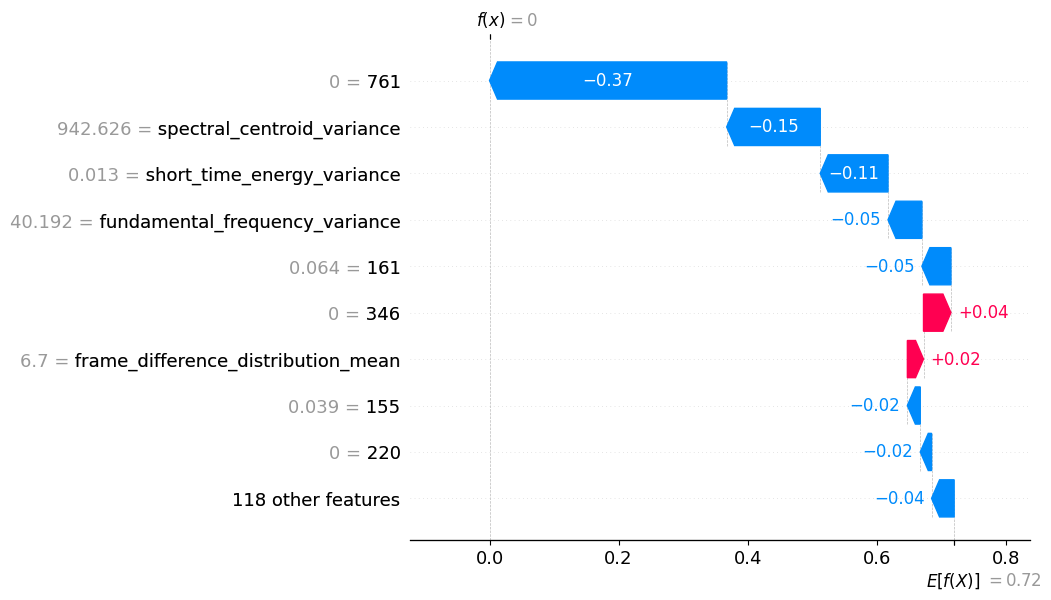

In [199]:
exp = shap.Explanation(
  sv.values, 
  sv.base_values[0], 
  sv.data, feature_names=list(small_final_x.columns)
)
shap.plots.waterfall(exp[a])

We can see that E[f(x)] = 0.72, you could call this the null hypothesis. Since 72% of the data is a commercial, the model default probability is 0.72. It then use the features to steer the conclusion to one side or another.

We can see that features frame_difference_distribution_mean, word 346 point toward it being commercial.

However the other features which have a lot more weight point in the other direction. As expected, those most important mean and variance features are about the same as the one identified in section 4. They obviously do not match exactly because in section 4 we looked at the avergage importance and this is a single example.

We can also learn from this chart that word 761 (which as mentioned in the beginning is not an actual word but a sound instead) strongly points toward Not Commercial when its value is 0 (note we can't be sure of that since this is a single example). That means that commercial tend to have this word/sound and non-commercial do not and it is a very good indicator.

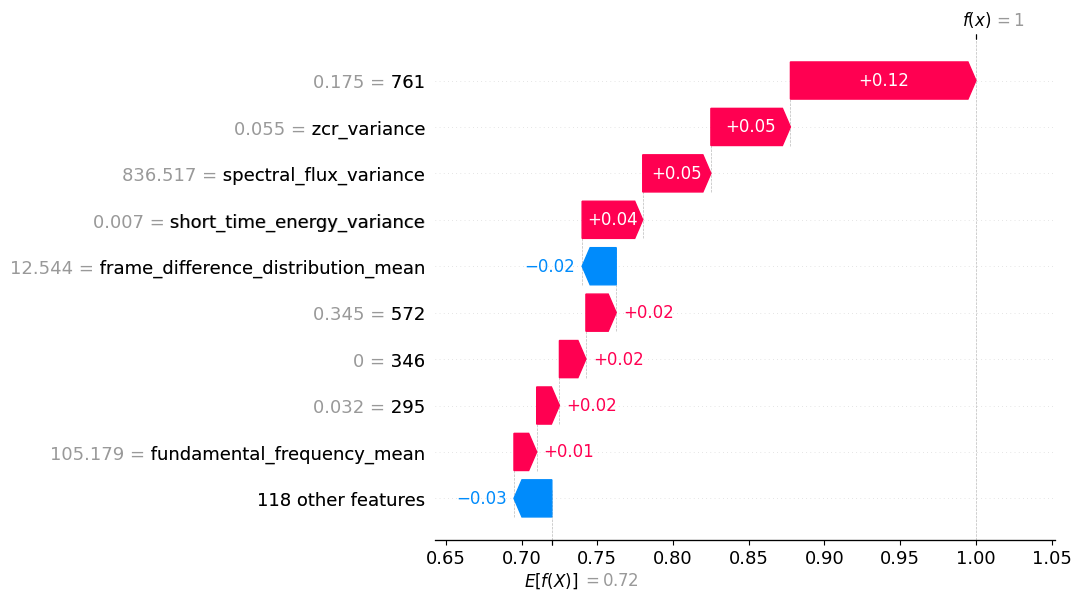

In [200]:
exp = shap.Explanation(
  sv.values, 
  sv.base_values[0], 
  sv.data, feature_names=list(small_final_x.columns)
)
shap.plots.waterfall(exp[b])

In this commercial example, 761 is not zero and it points toward commercial. Thus our hypothesis from the first example is probably right.

The zcr_variance also now appears as one of the top feature. Perhaps it usually has a very specific range for commercial, but not so much for non-commercial, thus making it only a top feature with a lot of weight when it is in that specific range. Now this is mostly a guess as of now since this is a single example, further analysis is needed.

It is common for features to have a asymetrical importance. Since we used a decision tree, we could confirm whether or not our features have asymetrical importance by checking if the tree is symetrical or not.

#### Let's try to understand the model better by visualizing it

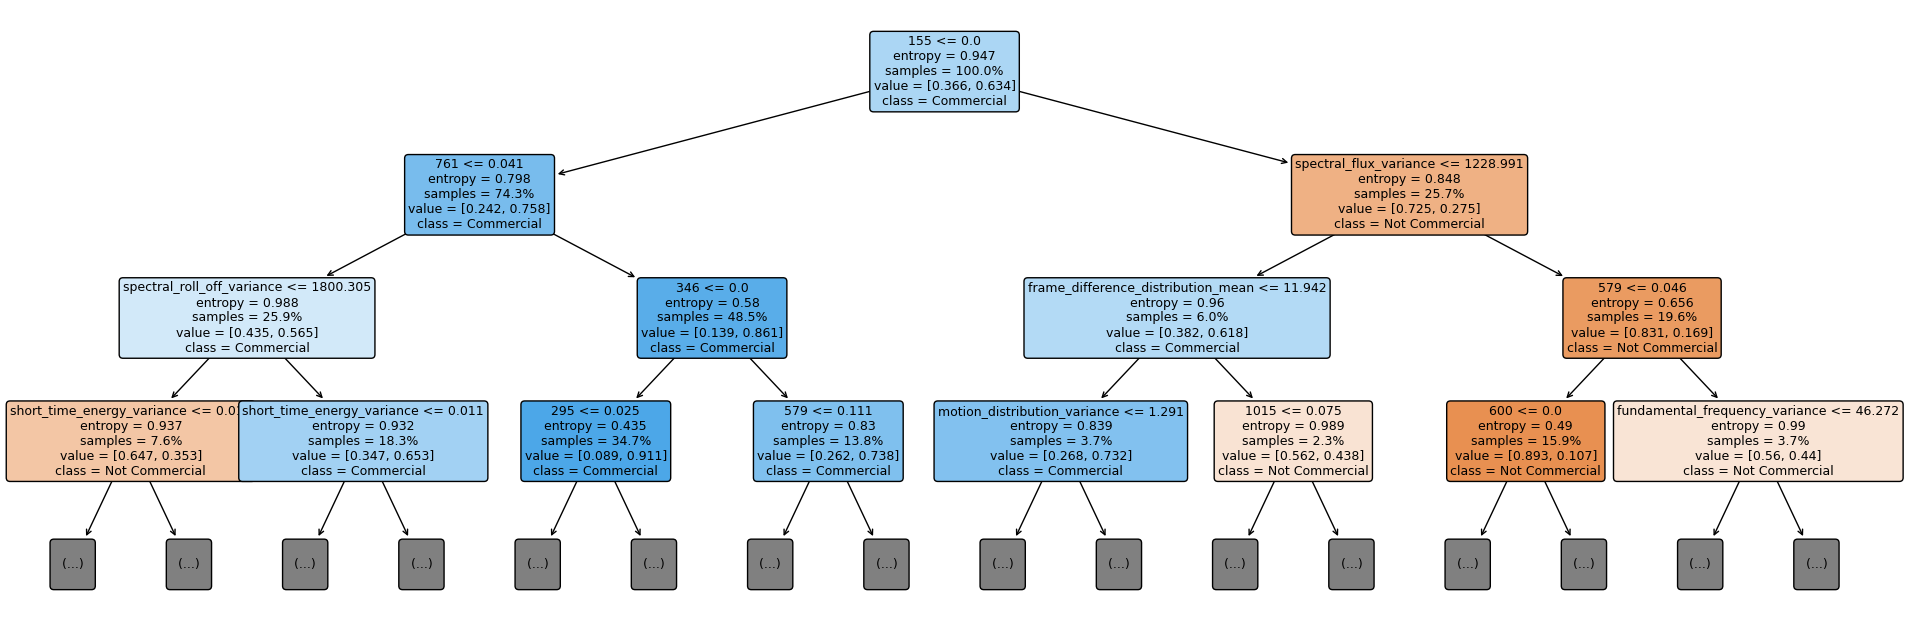

In [193]:
best_model.fit(final_x,final_y)
fig = plt.figure(figsize=(24, 8))
vis = tree.plot_tree(
  best_model, 
  feature_names = list(final_x.columns), 
  class_names = ['Not Commercial', 'Commercial'], 
  max_depth=3, 
  fontsize=9, 
  proportion=True, 
  filled=True, 
  rounded=True
)
fig.savefig("decision_tree.jpg")

Even with 3 layers, we can already tell that the tree isn't symetrical. Meaning that the importance of each feature is not perfectly the same for each label. As expected the top features are found at the top of the tree.

# Conclusion

In conclusion, even a simple model such as decision tree is good enough to detect commercial from visual and audio metadata about footage which are themselves a lot simpler than the actual footage.

One of the surprising thing we discovered that many of the features that had a large impact where found in the MFCC bag of audio words. This could mean that a certain audio sound are reliable predictors of whether the video is a commercial or not.

To extend further, there are many applications where a model of this type on similar data would be valuable. Autonomous vehicles need to decrypt their surroundings to navigate the real world. Perhaps instead of using resource intensive or complex computer vision, they could instead convert the footage in to metadata and then analyse it with a simple and fast model like we did. In addition, with the bag of words exploration, later did we realize that the bag of words did not actually represent the occurrences of certain words, but is an MFCC bag of audio words. This MFCC (Mel-frequency cepstral coefficients) which is a representation of the short-term power spectrum of a sound, relative to each other.

Given that we have 91% percent accuracy that might not be enough for autonomous vehicles. A better alternative use case would be to analyse security cameras/microphone to detect suspicious behaviour. This seems like a most likely use case as the amount of such footage is huge thus benefiting more from the faster performance and the consequence of an incorrect classification are not as dramatic.

There are many ways to keep on working on this project. For example, one could gather data on the asymetric predictive power of each feature in order to gain insights on the characteristics of each label. Also, our hyperparameter search was more smoke than fire because we search a very tiny parameter space and got an expectedly small improvement. Thus it would be valuable to take the time to run a grid search on a larger parameter space.


# Bibliography

Digital Watermarking Alliance. (n.d.). Broadcast Monitoring. Retrieved February 13, 2023, from https://digitalwatermarkingalliance.org/digital-watermarking-applications/broadcast-monitoring/


Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

Kotsiantis, S., Tsekouras, G., & Pintelas, P. E. (2005, January). Bagging Model Trees for Classification Problems. Researchgate. Retrieved February 14, 2023, from https://www.researchgate.net/publication/221565417_Bagging_Model_Trees_for_Classification_Problems 

scikit-learn. (n.d.). DecisionTreeClassifier - scikit-learn 0.24.2 documentation. Retrieved February 14, 2023, from https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html